In [1]:
import logging

def configure_logging(debug=False):
    if debug:
        logging.basicConfig(level=logging.DEBUG)
    else:
        logging.basicConfig(level=logging.INFO)
        
# Turn on debugging
configure_logging(debug=False)


# !pip install logging
# from dotenv import load_dotenv
# _ = load_dotenv()
#llama3-groq-70b-8192-tool-use-preview

import os
from langchain_groq import ChatGroq
import getpass
# KnowledgeGraphTool
import requests
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_core.tools import tool


from langchain_core.prompts import PromptTemplate


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph IoT Engine"
# Load a specific environment variable
GKGraph_API_KEY = os.environ.get('GKGraph_API_KEY')
TAVILY_API_KEY=os.environ.get('TAVILY_API_KEY')
# model = ChatGroq(model="llama3-8b-8192")
llm = ChatGroq(model="llama3-8b-8192" , temperature =0)

from tavily import TavilyClient
# Step 1. Instantiating your TavilyClient
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)



# !pip install langgraph-checkpoint-sqlite
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
import re
import json

db = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(db)


from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser()


def prepaer_states(json_obj):
    """
    Ensure all keys are present in the JSON object. 
    If a key is missing, set its value to None.

    Args:
        json_obj (dict): The JSON object to check.
        keys (list): List of keys to ensure in the JSON object.

    Returns:
        dict: The updated JSON object with all specified keys.
    """
    keys = ["messages", "handled", "make_sense", "node"]
    for key in keys:
        if key not in json_obj:
            json_obj[key] = [None]
    return json_obj

In [2]:
from langchain_core.output_parsers import JsonOutputParser
assistant_prompt= """
Act as an assistant  and answer user queries ONLY if you can 
User queries may fall into one of the following categories:
1- Greeting/General: Greeting you or answering a general question you can ONLY answer.
2- Service Recommendation: Asking for a recommendation for a service or a place to visit, such as I want to drink coffee, I am looking for a Middle Eastern restaurant, or Do you know any close hospital?
3- Hard Question: General questions you can't answer, such as: who is the current president of the United States of America? Or any question related to current events happening as you don't have access to the current event happening right now
Your response must follow the following JSON  objects based on each category:
 1- Greeting/General: you need to provide your response ONLY in a JSON object as shown:
 {
 "query-type": "greeting-general",
 "response": write your response here
}
2-Service Recommendation: try to extract the service type and the city, country, Address, or Coordinates if mentioned. Your response is ONLY a JSON object. This JSON object must follow the following structure and set false in bool format for the value of the keys that you can't extract.
 { 
    "query-type": "serivce-recommendation",
    "service": extracted service type, 
    "city": extracted city,
    "city": extracted country"
    "address": extracted address,
    "coordinates":[extracted  latitude, extracted longitude]
}
3- Hard Question/current events: you need to provide your response ONLY JSON object as shown:
{
 "query-type": "hard-question"
}

"""







In [3]:
from typing import TypedDict, Annotated, Sequence,List
import operator
from langchain_core.messages import BaseMessage,AnyMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    handled: Annotated[List[bool], operator.add]
    make_sense: Annotated[List[bool], operator.add]
    node: Annotated[List[str], operator.add]
        


In [32]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph,StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
TavilySearch = TavilySearchResults(max_results=2) #increased number of results
from langchain_core.messages import SystemMessage
def assistant_agent(state: AgentState):
    print("assistent node")
    agent_message={}
    agent_message["node"]=["assistant_agent"]
    logging.info("entering asstiant node")
    messages = state["messages"]
    print(f"messages: \n {messages}")
    
    prompt=list(messages)+[SystemMessage(content=assistant_prompt)]
    print(prompt)
    response = llm.invoke(prompt)
    print(response)
    agent_message["messages"]=[response]
#     agent_message["handled"]=[True]
    print("agent_message")
    return prepaer_states(agent_message)
    
def generator_agent(state: AgentState):
    return prepaer_states({"node":["generator-agent"]})

def reviewer_agent(state: AgentState):
    logging.info("entering reviewer node")
    dictionary= {"messages":[HumanMessage("Hi how are You? How I can help you")],"handled":[True], "make_sense":[True]}
    return prepaer_states(dictionary)

def IoT_engine(state: AgentState):
    logging.info("Using branch B")
    return input


def GoogleMaps(state: AgentState):
    logging.info("Using branch C")
    return input

def GoogleKnowledgeGraph(state: AgentState):
    logging.info("Using branch C")
    return input


def scrapper(state: AgentState):
        # Step 2. Executing a simple search query
    messages=state["messages"] 
    human_messages=""
    for  message in messages:
        if message.type =='human':
            human_messages+= " \n"+ message.content
    logging.info(human_messages)
    response = tavily_client.search(human_messages)
    if(response["results"][0]):
        search_result=response["results"]
        logging.info(search_result)
        return prepaer_states({"messages":[SystemMessage(str(search_result))], "handled":[True], "node":["scrapper"]})
    else:
        return prepaer_states({"handled":[False]})


def assitant_router(state: AgentState):
    logging.info("STATE at assitant_router:", state)
    messages = state["messages"]
    last_message = messages[-1]
    logging.info(last_message)
    response_json=parser.parse(last_message.content)
    if response_json["query-type"] == "greeting-general":
        logging.info("@assitant_router catch greeting-general")
        return "reviewer_agent"
    elif response_json["query-type"] == "service-recommendation": 
        logging.info("@assitant_router catch serivce-recommendation")
        return "IoT-engine"
    else:
        logging.info("@assitant_router no catch serivce-recommendation")
        return "scrapper"
        

def scrapper_router(state: AgentState):
    logging.info("STATE at assitant_router:", state)
    messages = state["messages"]
    last_message = messages[-1]
    logging.info(last_message)
    last_handled= state["handled"]
    logging.info(state["handled"])
    if  state["handled"]:
        logging.info("@scrapper_router and handled true")
        return "generator_agent"
    else:
        return "generator_agent"

def reviewer_router(state: AgentState):
    logging.info("I'm in reviewer router")
    if  state["make_sense"]:
        logging.info("Make sense True at reviewer writer")
        return "END"
    else:
        return "IoT_engine"


def router(state: AgentState):
    if  state["make_sense"]:
        return "END"
    else:
        return "IoT_engine"
# graph = MessageGraph()
graph=StateGraph(AgentState)
graph.add_node("assistant_agent", assistant_agent)
graph.add_node("generator_agent", generator_agent)
graph.add_node("IoT_engine", IoT_engine)
graph.add_node("GoogleMaps", GoogleMaps)
graph.add_node("GoogleKnowledgeGraph", GoogleKnowledgeGraph)
graph.add_node("scrapper", scrapper)
graph.add_node("reviewer_agent", reviewer_agent)


# graph.add_edge("assistant_agent", "reviewer_agent")
# graph.add_edge("assistant_agent", "IoT_engine")

graph.add_conditional_edges(
    "assistant_agent", assitant_router, {"reviewer_agent": "reviewer_agent", "IoT_engine": "IoT_engine", "scrapper":"scrapper"}
)


graph.add_conditional_edges(
    "scrapper", scrapper_router, {"generator_agent": "generator_agent", "GoogleMaps": "GoogleMaps"}
)

# graph.add_edge("IoT_engine", "generator_agent")
# graph.add_edge("IoT_engine", "GoogleMaps")

graph.add_conditional_edges(
    "IoT_engine", router, {"generator_agent": "generator_agent", "GoogleMaps": "GoogleMaps"}
)

# graph.add_edge("GoogleMaps", "generator_agent")
# graph.add_edge("GoogleMaps", "GoogleKnowledgeGraph")
graph.add_conditional_edges(
    "GoogleMaps", router, {"generator_agent": "generator_agent", "GoogleKnowledgeGraph": "GoogleKnowledgeGraph"}
)


# graph.add_edge("GoogleKnowledgeGraph", "generator_agent")
# graph.add_edge("GoogleKnowledgeGraph", "scrapper")
graph.add_conditional_edges(
    "GoogleKnowledgeGraph", router, {"generator_agent": "generator_agent","GoogleMaps":"GoogleMaps" , "scrapper": "scrapper"}
)

# graph.add_edge("scrapper", "generator_agent")

graph.add_edge("generator_agent","reviewer_agent")

graph.add_conditional_edges(
    "reviewer_agent", reviewer_router, { "scrapper": "scrapper", "GoogleMaps":"GoogleMaps" ,"END":END}
)


graph.set_entry_point("assistant_agent")

runnable = graph.compile(checkpointer=memory,  interrupt_before=["scrapper"])

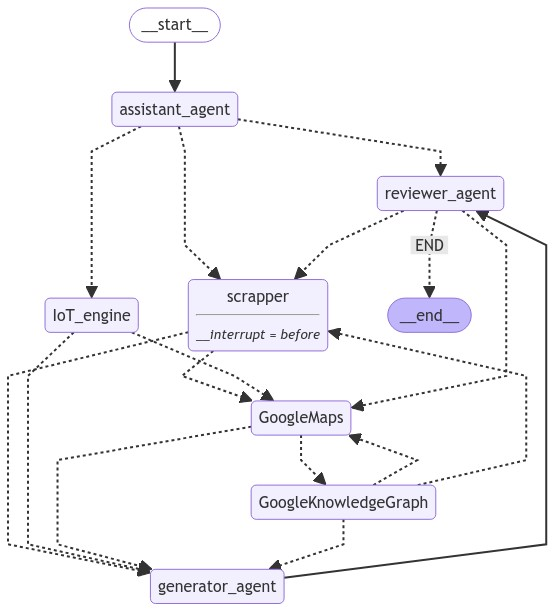

In [18]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [41]:
thread = {"configurable": {"thread_id": "125"}}


human_message = HumanMessage(content="Hi")
messages = [human_message]

result = runnable.invoke(prepaer_states({"messages":messages}), thread)

INFO:root:entering asstiant node


assistent node
messages: 
 [HumanMessage(content='Hi')]
[HumanMessage(content='Hi'), SystemMessage(content='\nAct as an assistant  and answer user queries ONLY if you can \nUser queries may fall into one of the following categories:\n1- Greeting/General: Greeting you or answering a general question you can ONLY answer.\n2- Service Recommendation: Asking for a recommendation for a service or a place to visit, such as I want to drink coffee, I am looking for a Middle Eastern restaurant, or Do you know any close hospital?\n3- Hard Question: General questions you can\'t answer, such as: who is the current president of the United States of America? Or any question related to current events happening as you don\'t have access to the current event happening right now\nYour response must follow the following JSON  objects based on each category:\n 1- Greeting/General: you need to provide your response ONLY in a JSON object as shown:\n {\n "query-type": "greeting-general",\n "response": write y

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:STATE at assitant_router:
INFO:root:content='{\n  "query-type": "greeting-general",\n  "response": "Hello! How can I assist you today?"\n}' response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 353, 'total_tokens': 380, 'completion_time': 0.02084447, 'prompt_time': 0.070954073, 'queue_time': None, 'total_time': 0.09179854300000001}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'stop', 'logprobs': None} id='run-91d0353c-317d-4357-9e3b-71b05718e652-0' usage_metadata={'input_tokens': 353, 'output_tokens': 27, 'total_tokens': 380}
INFO:root:@assitant_router catch greeting-general
INFO:root:entering reviewer node
INFO:root:I'm in reviewer router
INFO:root:Make sense True at reviewer writer


content='{\n  "query-type": "greeting-general",\n  "response": "Hello! How can I assist you today?"\n}' response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 353, 'total_tokens': 380, 'completion_time': 0.02084447, 'prompt_time': 0.070954073, 'queue_time': None, 'total_time': 0.09179854300000001}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_a97cfe35ae', 'finish_reason': 'stop', 'logprobs': None} id='run-91d0353c-317d-4357-9e3b-71b05718e652-0' usage_metadata={'input_tokens': 353, 'output_tokens': 27, 'total_tokens': 380}
agent_message


In [40]:
thread = {"configurable": {"thread_id": "350"}}


human_message = HumanMessage(content="do you know who invented the car")
messages = [human_message]

for event in runnable.stream(prepaer_states({"messages":messages}), thread):
    for v in event.values():
        print(v['messages'])

INFO:root:entering asstiant node


assistent node
messages: 
 [HumanMessage(content='do you know who invented the car')]
[HumanMessage(content='do you know who invented the car'), SystemMessage(content='\nAct as an assistant  and answer user queries ONLY if you can \nUser queries may fall into one of the following categories:\n1- Greeting/General: Greeting you or answering a general question you can ONLY answer.\n2- Service Recommendation: Asking for a recommendation for a service or a place to visit, such as I want to drink coffee, I am looking for a Middle Eastern restaurant, or Do you know any close hospital?\n3- Hard Question: General questions you can\'t answer, such as: who is the current president of the United States of America? Or any question related to current events happening as you don\'t have access to the current event happening right now\nYour response must follow the following JSON  objects based on each category:\n 1- Greeting/General: you need to provide your response ONLY in a JSON object as shown:\n

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:STATE at assitant_router:
INFO:root:content='{\n  "query-type": "hard-question"\n}' response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 359, 'total_tokens': 371, 'completion_time': 0.008791921, 'prompt_time': 0.072233304, 'queue_time': None, 'total_time': 0.08102522499999999}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_873a560973', 'finish_reason': 'stop', 'logprobs': None} id='run-1a0786a3-89ed-43c5-ac0e-e2ae9a88c810-0' usage_metadata={'input_tokens': 359, 'output_tokens': 12, 'total_tokens': 371}
INFO:root:@assitant_router no catch serivce-recommendation


content='{\n  "query-type": "hard-question"\n}' response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 359, 'total_tokens': 371, 'completion_time': 0.008791921, 'prompt_time': 0.072233304, 'queue_time': None, 'total_time': 0.08102522499999999}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_873a560973', 'finish_reason': 'stop', 'logprobs': None} id='run-1a0786a3-89ed-43c5-ac0e-e2ae9a88c810-0' usage_metadata={'input_tokens': 359, 'output_tokens': 12, 'total_tokens': 371}
agent_message
[AIMessage(content='{\n  "query-type": "hard-question"\n}', response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 359, 'total_tokens': 371, 'completion_time': 0.008791921, 'prompt_time': 0.072233304, 'queue_time': None, 'total_time': 0.08102522499999999}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_873a560973', 'finish_reason': 'stop', 'logprobs': None}, id='run-1a0786a3-89ed-43c5-ac0e-e2ae9a88c810-0', usage_metadata={'input_tokens': 359

In [39]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(content=assistant_prompt)
human_message = HumanMessage(content="can you suggest a place for my vecation?")
messages = [system_message, human_message]

result = runnable.invoke({"messages": messages, "api_call_count": 0})

INFO:root:entering asstiant node
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:STATE at assitant_router:
INFO:root:content='{\n    "query-type": "service-recommendation",\n    "service": "beach",\n    "city": false,\n    "country": false,\n    "address": false,\n    "coordinates": [false, false]\n}' response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 362, 'total_tokens': 411, 'completion_time': 0.038007151, 'prompt_time': 0.072840718, 'queue_time': None, 'total_time': 0.110847869}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_af05557ca2', 'finish_reason': 'stop', 'logprobs': None} id='run-ea2763eb-a709-46e8-9aa3-baa858d7ee46-0' usage_metadata={'input_tokens': 362, 'output_tokens': 49, 'total_tokens': 411}
INFO:root:@assitant_router catch serivce-recommendation


content='{\n    "query-type": "service-recommendation",\n    "service": "beach",\n    "city": false,\n    "country": false,\n    "address": false,\n    "coordinates": [false, false]\n}' response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 362, 'total_tokens': 411, 'completion_time': 0.038007151, 'prompt_time': 0.072840718, 'queue_time': None, 'total_time': 0.110847869}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_af05557ca2', 'finish_reason': 'stop', 'logprobs': None} id='run-ea2763eb-a709-46e8-9aa3-baa858d7ee46-0' usage_metadata={'input_tokens': 362, 'output_tokens': 49, 'total_tokens': 411}
agent_message


KeyError: 'IoT-engine'

In [10]:
result

{'messages': [SystemMessage(content='\nAct as an assistant  and answer user queries ONLY if you can \nUser queries may fall into one of the following categories:\n1- Greeting/General: Greeting you or answering a general question you can ONLY answer.\n2- Service Recommendation: Asking for a recommendation for a service or a place to visit, such as I want to drink coffee, I am looking for a Middle Eastern restaurant, or Do you know any close hospital?\n3- Hard Question: General questions you can\'t answer, such as: who is the current president of the United States of America? Or any question related to current events happening as you don\'t have access to the current event happening right now\nYour response must follow the following JSON  objects based on each category:\n 1- Greeting/General: you need to provide your response ONLY in a JSON object as shown:\n {\n "query-type": "greeting-general",\n "response": write your response here\n}\n2-Service Recommendation: try to extract the serv

In [11]:
import pandas as pd
df=pd.DataFrame(result)
df.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,messages,handled,make_sense,node
0,content='\nAct as an assistant and answer use...,None,None,None
1,content='who is the current president of Egypt',None,None,None
2,"content='{\n ""query-type"": ""hard-question""\n}...",None,None,assistant_agent
3,content='{\'title\': \'List of presidents of E...,True,None,scrapper
4,None,None,None,generator-agent


In [34]:
result

{'messages': [SystemMessage(content='\nAct as an assistant  and answer user queries ONLY if you can \nUser queries may fall into one of the following categories:\n1- Greeting/General: Greeting you or answering a general question you can ONLY answer.\n2- Service Recommendation: Asking for a recommendation for a service or a place to visit, such as I want to drink coffee, I am looking for a Middle Eastern restaurant, or Do you know any close hospital?\n3- Hard Question: General questions you can\'t answer, such as: who is the current president of the United States of America? Or any question related to current events happening as you don\'t have access to the current event happening right now\nYour response must follow the following JSON  objects based on each category:\n 1- Greeting/General: you need to provide your response ONLY in a JSON object as shown:\n {\n "query-type": "greeting-general",\n "response": write your response here\n}\n2-Service Recommendation: try to extract the serv